# Load .mat file

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
filePath = '/Users/ivanaescobar/Dropbox/UT_CSEM_2016-202*/research/crios_research/ARL_nesba/YT_data_fig_Sharp_ssp/'
fileName = 'Sharp_xshelf_ctd59-69.mat'
file = filePath + fileName

In [3]:
mat = scipy.io.loadmat(file)
keys_to_remove = ("__header__", "__version__", "__globals__")
for k in keys_to_remove:
    mat.pop(k, None)

In [4]:
print(type(mat))
print(mat.keys())

<class 'dict'>
dict_keys(['ibdpth', 'idpth', 'ilat', 'ilon', 'isalt', 'isvcm', 'itemp', 'lat', 'lon', 'salt', 'sname', 'svcm', 'temp'])


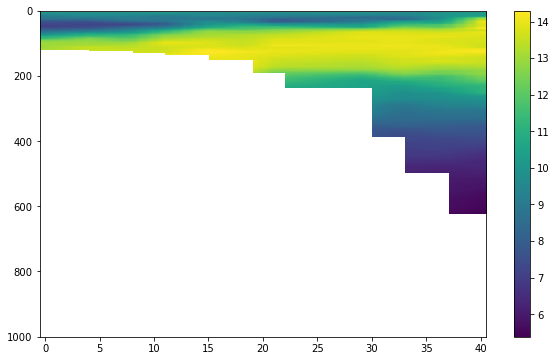

In [5]:
plt.figure(figsize=(10,6))
plt.imshow(mat["itemp"], aspect="auto")
plt.colorbar()

# Convert to xarray DataSet

modify dictionary to use **from_dict** xarray method

only saving:
- *ibdpth*: Dimension of dataSet
- *idpth*: Dimension of dataSet
- *ilat*: unused latitutdes 
- *ilon*: unused longitutdes 
- *isalt*: Data variable salinity
- *isvcm*: Data variable sound speed
- *itemp*: Data variable temperature

Other info: 
* Send source signature from TM4 experiment for time series modeling : \
TM4 source 4 second long chirp, bandwidth 775 Hz – 475 Hz.  Source depth:  81 m \
* Send lat, lon, depth coordinates of TM4 and AT: \
TM4:  39° 50.8542'N 70° 54.0876'W;  \
AT:  39° 57.150'N   70° 53.167'W

In [6]:
import xarray as xr

In [7]:
r = [(len(mat["ibdpth"])-i-1)/10 for i in range(len(mat["ibdpth"]))]
z = [i for i in range(len(mat["idpth"]))]

In [8]:
d = {
    "r":     {"dims": ("r"),     "data":r},
    "z":     {"dims": ("z"),     "data":z},
    "depth": {"dims": ("r"),     "data":list(mat["ibdpth"].flat)},
    "lat":   {"dims": ("r"),     "data":list(mat["ilat"].flat)},
    "lon":   {"dims": ("r"),     "data":list(mat["ilon"].flat)},
    "salt":  {"dims": ("z","r"), "data":mat["isalt"].tolist()},
    "temp":  {"dims": ("z","r"), "data":mat["itemp"].tolist()},
    "ss":    {"dims": ("z","r"), "data":mat["isvcm"].tolist()}
}
ds = xr.Dataset.from_dict(d)
ds = ds.sortby('r')

In [9]:
ds.r.attrs['long_name'] = 'range?'
ds.r.attrs['unit'] = 'km'
ds.z.attrs['long_name'] = 'depth'
ds.z.attrs['unit'] = 'm'
ds.depth.attrs['long_name'] = 'maximum depth'
ds.depth.attrs['unit'] = 'm'
ds.ss.attrs['long_name'] = 'sound speed'
ds.ss.attrs['unit'] = 'm/s'

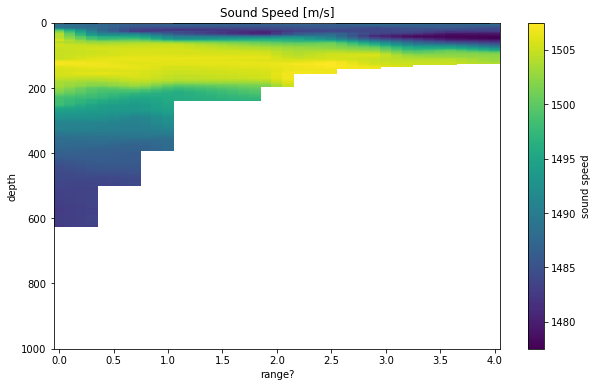

In [10]:
plt.figure(figsize=(10,6))
ds.ss.plot(yincrease=False)
plt.title('Sound Speed [m/s]');

In [11]:
ds

<xarray.Dataset>
Dimensions:  (r: 41, z: 1001)
Coordinates:
  * r        (r) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 ... 3.5 3.6 3.7 3.8 3.9 4.0
  * z        (z) int64 0 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
Data variables:
    depth    (r) float64 872.3 814.3 759.3 695.3 ... 130.1 128.5 127.1 125.7
    lat      (r) float64 39.85 39.86 39.87 39.88 ... 40.19 40.2 40.21 40.22
    lon      (r) float64 -70.89 -70.88 -70.88 -70.88 ... -70.91 -70.91 -70.91
    salt     (z, r) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    temp     (z, r) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ss       (z, r) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

# Write BTYFile

BELLHOP BTYFile is written as follows: 

`interpolation type`\
`number of bathymetry points, nBtyPts`\
`range(1)   depth(1)`\
`...`\
`range(nBtyPts)   depth(nBtyPts)`

In [12]:
pathBTY = '/Users/ivanaescobar/work/sandbox/at_2020_11_4/Bellhop/nesba/'
fileBTY = 'nesba-tm4.bty'
TypeBTY = "'L'"
nPtsBTY = len(ds.r)

In [13]:
dataBTY = np.column_stack([ds.r, ds.depth])

In [14]:
np.savetxt(pathBTY+fileBTY, dataBTY, fmt=['%0.1f', '%0.6f'], 
           header=TypeBTY + '\n' + str(nPtsBTY), comments='',
           delimiter='\t')

# Write SSPFile

BELLHOP SSPFile is written as follows: 

`number of SSP Ranges, SSP%Nr`\
`ranges in km`\
`SSP for each range at z(1)`\
`...`\
`SSP for each range at z(1001)`

In [15]:
pathSSP = pathBTY
fileSSP = 'nesba-tm4.ssp'
nPtsSSP = len(ds.r)

### SSP nan values

there are nan values where the ssp could not be calculated for reasons not yet known by me. 

1) nan values below the bathymetry will be set to the groundfloor sound speed, 1600 m/s. \
2) nan values in the water column are replaced with the mean ssp in the domain. 


In [16]:
ds['ssmod1'] = ds.ss.where(ds.z < ds.depth, 1600.00)

In [17]:
ds['ssmod2'] = ds.ssmod1.where(ds.ssmod1.isnull() == False, 
                               ds.ss.mean(skipna=True) )

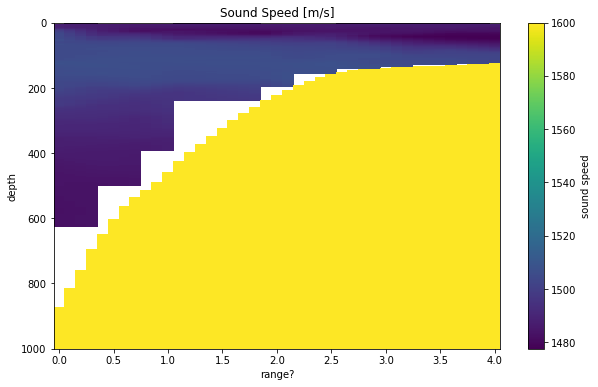

In [18]:
plt.figure(figsize=(10,6))
ds.ssmod1.plot(yincrease=False)
plt.title('Sound Speed [m/s]');

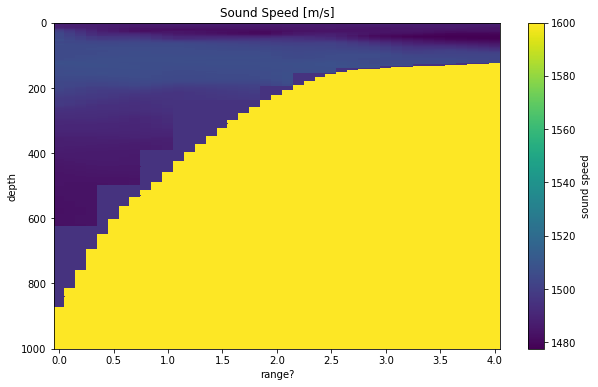

In [19]:
plt.figure(figsize=(10,6))
ds.ssmod2.plot(yincrease=False)
plt.title('Sound Speed [m/s]');

### Write to SSPFile


In [20]:
dataSSP = np.vstack([dataBTY[:,0], ds.ssmod2])

In [21]:
np.savetxt(pathSSP+fileSSP, 
           dataSSP, fmt='%0.6f', 
           header=str(nPtsSSP), comments='',
           delimiter='\t')

# Write first column of SSP in ENVFile

BELLHOP ENVFile requires there be # of depths amount of rows with dummy SSP values to read in. It uses this to dtermine how big the SSPFile will be and will allocate memory for the SSP matrices with this.

In [25]:
pathENV = pathBTY
dataENV = np.column_stack([ds.z, ds.ssmod2.isel(r=0)])

In [26]:
np.savetxt(pathENV+'nesba-tm4-extension.env', 
           dataENV, fmt=['%0.1f', '%0.6f'], 
           delimiter='\t',
           newline='\t/\n')

# Save data set to netcdf

In [27]:
ds.to_netcdf(pathENV+'nesba-tm4.nc')

<sub> Written by Ivana Escobar on June 2022